In [1]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.metrics import MeanIoU
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

# Constructions des différents modules du UNet

Resnet Sub-block

In [2]:
def res_block(input, channels, kernel=(3,3), dil = (1,1), stride= (1,1), act= 'relu', bn= True, kernel_init='he_normal'): 
  """Simple build of a 2D residual block containing 2 2D convolutions

  Input --> Conv2D > ReLu > BN --> Conv2D > BN --> + > ReLU --> Output
        |                                          |
        +---------(compression conv2D 1x1)---------+

  - input : Block input volume.
  - channels : Number of output channels. If "channels" value is inferior to input channels, a compression is automatically made with a 1*1conv in the identity branch. 
  - kernel : Kernel size to use in all convolutions (except in the compression one).
  - dil : Dilation to use (default = (1,1)).
  - stride : Stride to use (default = (1,1)).
  - act = Activation function (default = 'relu').
  - bn = Bacth Normalization, if set to True, add a BN after each convolution (default = True).
  - compression = Adds a compression convolution in the identity branch. If set to True, it will compress the input into the number of channels chosen with "channels" (default = False).
  - kernel_init = Kernel initializer (default = 'he_normal')
  """

  conv1 = Conv2D(
      channels, 
      kernel,
      strides=stride, 
      dilation_rate = dil,
      activation=act,
      padding='same',
      kernel_initializer=kernel_init)(input)
  norm1 = BatchNormalization()(conv1)  

  conv2 = Conv2D(
      channels, 
      kernel,
      strides=stride, 
      dilation_rate = dil,
      padding='same',
      kernel_initializer=kernel_init)(norm1)
  norm2 = BatchNormalization()(conv2)        

  if channels < input.shape[-1]:
    # print('COMPRESSION ON')
    comp_conv = Conv2D(
        channels, 
        kernel_size = (1,1),
        padding='same',
        kernel_initializer=kernel_init)(input)
    comp_norm = BatchNormalization()(comp_conv)

    summed_branches = add([comp_conv, conv2])

  else:
    # print('COMPRESSION OFF')
    summed_branches = add([input, norm2])

  output = ReLU()(summed_branches)

  return output


# x = np.arange(0,16, dtype= 'float').reshape(1,2,2,4) 
# res_block(x,4)



Dual Receptive Field Res Block

In [3]:
def dual_RF_block(input, channels, lrf_kernel, srf_kernel, lrf_dil = (3,3), srf_dil = (1,1), stride = (1,1), act= 'relu', bn= True, sp_dropout = False, kernel_init='he_normal'):
  """Builds the dual Receptive Field sub-block with the Small Receptive Field branch (SRF) and the Large Receptive Field branch (LRF). By our definition, only the dilation must be different with lrf_stride > srf_stride.
  BE WAWARE: THE NUMBER OF FINAL OUTPUT CHANNELS IS 2*"CHANNELS" BECAUSE EACH RF BRANCH OUTPUTS A VOLUME OF "CHANNELS" DEPTH
           +-------- LRF Branch --------+
           |                            |
  Input ---+                            +---> output
           |                            |
           +-------- SRF Branch --------+

  - input : Block input volume.
  - channels : Number of output channels. If "channels" value is inferior to input channels, a compression is automatically made with a 1*1conv in the identity branch. 
  - lrf_kernel : Kernel size to use in all LRF branch convolutions (except in the compression one).
  - srf_kernel : Kernel size to use in all SRF branch convolutions (except in the compression one).
  - lrf_dil : Dilation to use in the LRF branch (default = (1,1)).
  - srf_dil : Dilation to use in the SRF branch (default = (1,1)).
  - stride : Stride to use (default = (1,1)).
  - act = Activation function (default = 'relu').
  - bn = Bacth Normalization, if set to True, add a BN after each convolution (default = True).
  - sp_dropout = Spatial dropout (default = False).
  - compression = Adds a compression convolution in the identity branch. If set to True, it will compress the input into the number of channels chosen with "channels" (default = False).
  - kernel_init = Kernel initializer (default = 'he_normal')
  """

  lrf_block = res_block(input, channels, lrf_kernel, dil = lrf_dil, stride = stride, act= act, bn= bn,  kernel_init=kernel_init)
  srf_block = res_block(input, channels, srf_kernel, dil = srf_dil, stride = stride, act= act, bn= bn,  kernel_init=kernel_init)

  output = concatenate([lrf_block, srf_block], axis=-1)
  
  if sp_dropout:
    output = SpatialDropout2D(sp_dropout)(output)

  return output

Type 1a Block and Type 1b Block

In [4]:
def t1_block(input, channels, lrf_kernel, srf_kernel, lrf_dil = (3,3), srf_dil = (1,1), stride = (1,1), act= 'relu', bn= True, sp_dropout = False, maxpool= (2,2), kernel_init='he_normal'):
  """Builds the dual Receptive Field sub-block with the Small Receptive Field branch (SRF) and the Large Receptive Field branch (LRF). By our definition, only the dilation must be different with lrf_stride > srf_stride.
  BE WAWARE: THE NUMBER OF FINAL OUTPUT CHANNELS IS 2*"CHANNELS" BECAUSE EACH RF BRANCH OUTPUTS A VOLUME OF "CHANNELS" DEPTH
                          +-------- LRF Branch --------+
                          |                            |
  Input ---> Res Block ---+                            +-----> Maxpooling --> Output
                          |                            |    |
                          +-------- SRF Branch --------+    +-----> Output (for skip connection)

  - input : Block input volume.
  - channels : Number of output channels. If "channels" value is inferior to input channels, a compression is automatically made with a 1*1conv in the identity branch. 
  - lrf_kernel : Kernel size to use in all LRF branch convolutions (except in the compression one).
  - srf_kernel : Kernel size to use in all SRF branch convolutions (except in the compression one).
  - lrf_dil : Dilation to use in the LRF branch (default = (1,1)).
  - srf_dil : Dilation to use in the SRF branch (default = (1,1)).
  - stride : Stride to use (default = (1,1)).
  - act = Activation function (default = 'relu').
  - bn = Bacth Normalization, if set to True, add a BN after each convolution (default = True).
  - sp_dropout = Spatial dropout (default = False).
  - kernel_init = Kernel initializer (default = 'he_normal')
  """

  #The base block uses the same values as the SRF branch, because by design they are the same
  base_res_block_out = res_block(input, channels, srf_kernel, dil = srf_dil, stride = stride, act= act, bn= bn, kernel_init=kernel_init)

  dual_rf_out = dual_RF_block(base_res_block, channels, lrf_kernel, srf_kernel, lrf_dil = lrf_dil, srf_dil = srf_dil, stride = stride, act= act, bn= bn, sp_dropout = sp_dropout, kernel_init=kernel_init)

  if maxpool:
    pool = MaxPooling2D(pool_size=maxpool)(dual_rf_out) 
    return pool, dual_rf_out

  else:
    return dual_rf_out

Type 2a Block and Type 2b BLock

In [5]:
def t2_block(input, channels, lrf_kernel=(3,3), srf_kernel=(3,3), lrf_dil = (3,3), srf_dil = (1,1), stride = (1,1), act= 'relu', bn= True, sp_dropout = False, maxpool= (2,2),  kernel_init='he_normal'):
  """Builds the dual Receptive Field sub-block with the Small Receptive Field branch (SRF) and the Large Receptive Field branch (LRF). By our definition, only the dilation must be different with lrf_stride > srf_stride.
  BE WAWARE: THE NUMBER OF FINAL OUTPUT CHANNELS IS 2*"CHANNELS" BECAUSE EACH RF BRANCH OUTPUTS A VOLUME OF "CHANNELS" DEPTH
           +-------- LRF Branch --------+
           |                            |
  Input ---+                            +-----> Maxpooling --> Output
           |                            |    |
           +-------- SRF Branch --------+    +-----> Output (for skip connection)

  - input : Block input volume.
  - channels : Number of output channels.
  - lrf_kernel : Kernel size to use in all LRF branch convolutions (except in the compression one).
  - srf_kernel : Kernel size to use in all SRF branch convolutions (except in the compression one).
  - lrf_dil : Dilation to use in the LRF branch (default = (1,1)).
  - srf_dil : Dilation to use in the SRF branch (default = (1,1)).
  - stride : Stride to use (default = (1,1)).
  - act = Activation function (default = 'relu').
  - bn = Bacth Normalization, if set to True, add a BN after each convolution (default = True).
  - sp_dropout = Spatial dropout (default = False).
  - compression = Adds a compression convolution in the identity branch. If set to True, it will compress the input into the number of channels chosen with "channels" (default = False).
  - kernel_init = Kernel initializer (default = 'he_normal')
  """

  dual_rf_out = dual_RF_block(input, channels, lrf_kernel, srf_kernel, lrf_dil = lrf_dil, srf_dil = srf_dil, stride = stride, act= act, bn= bn, sp_dropout = sp_dropout, kernel_init=kernel_init)

  if maxpool:
    pool = MaxPooling2D(pool_size=maxpool)(dual_rf_out)
    return pool, dual_rf_out
  else:
    return dual_rf_out


Attention module

In [6]:
def chan_attn_module(input):
  glob_avg = GlobalAveragePooling2D()(input)
  # print('global avg shape', glob_avg.shape) 
  # print('global avg ', glob_avg)
  
  # chan_conv1 = Conv2D(glob_avg.shape[-1], 
  #     1,
  #     1,
  #     activation = 'relu',
  #     padding='same',
  #     kernel_initializer='he_normal')(glob_avg)
  # chan_weights = Conv2D(glob_avg.shape[-1], 
  #     1,
  #     1,
  #     activation = 'sigmoid',
  #     padding='same',
  #     kernel_initializer='he_normal')(chan_conv1)

  chan_att_DL1 = Dense(glob_avg.shape[-1]/2, activation= 'relu')(glob_avg)
  # print(chan_att_DL1.shape)
  chan_att_DL2 = Dense(chan_att_DL1.shape[-1]*2, activation= 'sigmoid')(chan_att_DL1)
  # print(chan_att_DL2.shape) 
  # print(chan_att_DL2) 
  chan_att = multiply([chan_att_DL2, input])
  return chan_att 



def sp_attn_module(input):
  spacial_weights = Conv2D(
      1, 
      1,
      strides=1, 
      activation = 'sigmoid',
      padding='same',
      kernel_initializer='he_normal')(input)
    
  # print('Spacial_weigths shape', spacial_weights.shape)
  # print("Spacial_weihts :", spacial_weights)
  spacial_att = multiply([spacial_weights,input])

  # print("spacial_att shape:", spacial_att.shape)
  return spacial_att

def sc_att_module(input_volume):
  c = chan_attn_module(input_volume)
  s = sp_attn_module(input_volume)
  att_out = s+c
  # print(att_out.shape)
  return att_out

# from tensorflow import random

# input_shape = (1, 28, 28, 4)
# x = random.normal(input_shape)

# x = np.arange(0,16, dtype= 'float').reshape(1,2,2,4) 
# print("X: ",x)

# chan_att = sc_att_module(x)

# print("ATT:",chan_att)-+


Focal Tversky Loss

In [7]:
from keras.losses import binary_crossentropy

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.9
    smooth = 1
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

#Keras
def IoULoss(targets, inputs, smooth=1):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU

#**Model construction**


In [25]:
def unet(pretrained_weights=None, baseHW=8, input_size=(650, 650, 1), loss= focal_tversky, model_name='UNet_t2_att', sp_dropout = False, learning_rate = 1e-4, metrics = ['accuracy', dsc]):

    inputs = Input(input_size)

    base_volume = res_block(inputs,baseHW,3)
    # print(base_volume.shape)

    pool1,skip1 = t2_block(base_volume, baseHW, sp_dropout= sp_dropout) #output depth 2x16 = 32

    # print(pool1.shape)
    pool2,skip2 = t2_block(pool1, baseHW*2) #output depth 2x32 = 64

    # print(pool2.shape)    
    pool3,skip3 = t2_block(pool2, baseHW*4) #output depth 2x64 = 128

    # print(pool3.shape)
    center = t2_block(pool3, baseHW*8, maxpool=False) #output depth 2x128 = 256

    up3 = Conv2DTranspose(baseHW*8,4,2,padding="same")(center) #output depth 128
    am3 = sc_att_module(concatenate([up3, skip3])) #output depth 256
    D3 = t2_block(am3,baseHW*4, maxpool=False) #output depth 2x32 = 64

    up2 = Conv2DTranspose(baseHW*4,4,2,padding="same")(D3) #output depth 32
    am2 = sc_att_module(concatenate([up2, skip2])) #output depth 64
    D2 = t2_block(am2,baseHW*2, maxpool=False) #output depth 2x16 = 32

    up1 = Conv2DTranspose(baseHW*2,4,2,padding="same")(D2) #output depth 16 
    am1 = sc_att_module(concatenate([up1, skip1])) #output depth 32
    D1 = t2_block(am1,baseHW, maxpool=False) #output depth 2x8 = 16

    out_1 = res_block(D1,baseHW,3)

    out_conv = Conv2D(1, 1, activation='sigmoid', padding='same')(out_1)

    model = Model(inputs=inputs, outputs=out_conv, name=model_name)

    # compilation
    model.compile(optimizer=Adam(lr=learning_rate), loss=loss, metrics=metrics)

    model.summary()

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    model.save(model_name)

    #plot_model(model, show_shapes=True)
    return model

    #model = fass_model(input_size=(240, 240, 1), loss=focal_tversky, model_name='test', sp_dropout = 0.15, learning_rate = 1e-4)

In [9]:
def unet_membrane(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


# **Data preparation**

In [10]:
# import os
# import shutil
# from numpy import random

# def shuffle_dataset(prob, source_folder, source_images, source_masks, dest_folder):
	
# 	# masks = os.listdir(source_folder + source_masks)
# 	if source_folder[-1] != '/':
# 		source_folder + '/'
# 	if source_images[-1] != '/':
# 		source_images += '/'
# 	if source_masks[-1] != '/':
# 		source_masks += '/' 
# 	if dest_folder[-1] != '/':
# 		dest_folder += '/' 
# 	if not os.path.exists(dest_folder):
# 		os.makedirs(dest_folder)
# 		os.makedirs(dest_folder+'images/')
# 		os.makedirs(dest_folder+'masks/')
  


# 	files = os.listdir(source_folder + source_images)
# 	for f in files :
# 		if random.rand(1) < prob:
# 			shutil.move(source_folder+source_images+f, dest_folder+'images/')
# 			shutil.move(source_folder+source_masks+f, dest_folder+'masks/')

# 	return (dest_folder+'train/', dest_folder+'test/')
 
# shuffle_dataset(0.3,'/content/drive/MyDrive/Drive projet Deep Learning FOR/0 - Ressources du projet précédent/original_dataset/','images','masks/','/content/current_dataset')

In [20]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob
import skimage.io as io
import skimage.transform as trans


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)



def testGenerator(test_path, image_path, mask_path, target_size=(672,672), flag_multi_class=False, as_gray=True):
    if test_path[-1] != '/':
        test_path + '/'
    if image_path[-1] != '/':
        image_path += '/'
    if mask_path[-1] != '/':
        mask_path += '/' 

    for f in os.listdir(test_path + image_path):
        # print(counter)
        # counter += 1
        img = io.imread(test_path + image_path + f, as_gray=as_gray)
        img = img / 255
        img = trans.resize(img, target_size)
        img = np.reshape(img, img.shape + (1,)
                         ) if (not flag_multi_class) else img
        img = np.reshape(img, (1,) + img.shape)
        #img = np.concatenate((img, np.flip(img, 1)), axis=3)

        mask = io.imread(test_path + image_path + f, as_gray=as_gray)
        mask = mask / 255
        mask = trans.resize(mask, target_size)
        mask = np.reshape(mask, mask.shape + (1,)
                         ) if (not flag_multi_class) else mask
        mask = np.reshape(mask, (1,) + mask.shape)

        yield (img, mask)

def labelVisualize(num_class, color_dict, img):
    img = img[:, :, 0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i, :] = color_dict[i]
    return img_out / 255


def saveResult(save_path, npyfile, flag_multi_class=False, num_class=2):
    for i, item in enumerate(npyfile):
        img = labelVisualize(num_class, COLOR_DICT,
                             item) if flag_multi_class else item[:, :, 0]
        io.imsave(os.path.join(save_path, "%d_predict.png" % i), img)

# **Training**

In [21]:
#Using another dataset to train model eand test it

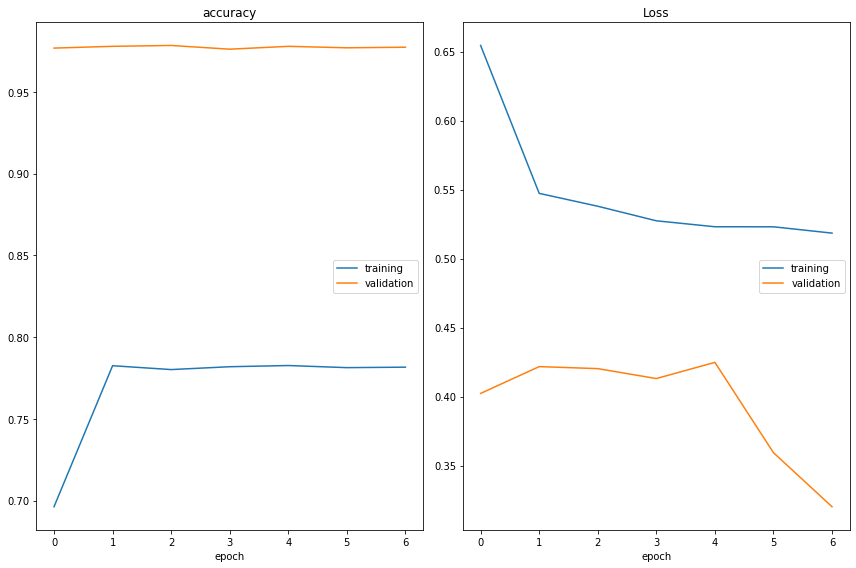

accuracy
	training         	 (min:    0.696, max:    0.783, cur:    0.782)
	validation       	 (min:    0.976, max:    0.978, cur:    0.977)
Loss
	training         	 (min:    0.518, max:    0.654, cur:    0.518)
	validation       	 (min:    0.320, max:    0.425, cur:    0.320)
6/6 [==============================] - 8s 1s/step - loss: 0.5185 - accuracy: 0.7816 - val_loss: 0.3203 - val_accuracy: 0.9774
Epoch 8/20
6/6 [==============================] - ETA: 0s - loss: 0.5171 - accuracy: 0.7807
Epoch 00008: loss improved from 0.51847 to 0.51708, saving model to models/model_17_membrane\model_17_membrane_lowres.h5


KeyboardInterrupt: 

In [22]:
from livelossplot import PlotLossesKerasTF



data_gen_args_1 = dict(featurewise_center=False,
                         featurewise_std_normalization=False,
                         rotation_range=90,
                         width_shift_range=0.15,
                         height_shift_range=0.15,
                         zoom_range=0.3,
                         horizontal_flip = True,
                         shear_range = 0.08,
                         fill_mode = 'nearest',
                         rescale = 1./255)


data_gen_args_2 = dict(featurewise_center=False,
                         featurewise_std_normalization=False,
                         fill_mode = 'nearest',
                         rescale = 1./255)



dim_image = 256
batch_size = 5
target_size = (dim_image,dim_image)

model_index = '17_membrane'
model_path = f"models/model_{model_index}"
if not os.path.exists(model_path):
    os.mkdir(model_path)
    

#train_data_generator = trainGenerator(batch_size,'test_dataset/unet-master/data/membrane/train/','image','label',data_gen_args, TEST_TRANSFORM,target_size=target_size, image_save_prefix=None, mask_save_prefix=None, save_to_dir = None)
#validation_data_generator = validationGenerator('test_dataset/unet-master/data/membrane/test/','image','label',target_size=target_size)
#train_data_generator = trainGenerator(batch_size,'old_dataset/train/','images','masks',data_gen_args, TEST_TRANSFORM,target_size=target_size, image_save_prefix=None, mask_save_prefix=None, save_to_dir = None)
#validation_data_generator = validationGenerator('old_dataset/test/','images','masks',target_size=target_size)


train_generator = trainGenerator(5,'test_dataset/unet-master/data/membrane/train', 'image','label',data_gen_args_1)

test_generator = trainGenerator(5,'test_dataset/unet-master/data/membrane/test', 'image','label',data_gen_args_2)



    
baseHW = 8
#model = unet(input_size=(dim_image, dim_image, 1),baseHW=baseHW, loss='binary_crossentropy', model_name=f"{model_path}/model_{model_index}_lowres", sp_dropout = 0.15, learning_rate = 1e-4)
model = unet_membrane()

model_checkpoint = ModelCheckpoint(
    model_path+f"/model_{model_index}_lowres.h5", monitor='loss', verbose=1, save_best_only=True, mode="min")


live_loss = PlotLossesKerasTF()


hstry = model.fit(
    x = train_generator,
    batch_size = None,
    epochs=20,
    verbose=1,
    callbacks=[model_checkpoint,live_loss],
    validation_split=None,
    validation_data= test_generator,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch= np.ceil(30 / batch_size),
    validation_steps= np.ceil(30 / batch_size),
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=1,
    workers=1,
    use_multiprocessing=False
)

#with open(f"{model_path}/trainHistoryDict_{model_index}", 'wb') as file_pi:
#        pickle.dump(hstry.history, file_pi)


In [19]:
model.load_weights(f"{model_path}/model_{model_index}_lowres.h5")
        
test_generator = testGenerator('test_dataset/unet-master/data/membrane/test/', 
               'image',
               'label')
#test_data_generator = trainGenerator('test_dataset/unet-master/data/membrane/test/','image','label',target_size=target_size)
#test_data_generator = trainGenerator('old_dataset/test/','images','masks',target_size=target_size)
model.evaluate(test_generator,verbose=1)

test_generator = testGenerator('test_dataset/unet-master/data/membrane/test/', 'image','label')

#test_data_generator = testGenerator('test_dataset/unet-master/data/membrane/test/','image','label',target_size=target_size)
#test_data_generator = testGenerator('old_dataset/test/','images','masks',target_size=target_size)
results = model.predict(test_generator,verbose=1)

if not os.path.exists(f"{model_path}/results_test_{model_index}"):
    os.mkdir(f"{model_path}/results_test_{model_index}")
saveResult(f"{model_path}/results_test_{model_index}",results)

test_train_generator = testGenerator('test_dataset/unet-master/data/membrane/train/', 
               'image',
               'label')

#test_data_generator = testGenerator('test_dataset/unet-master/data/membrane/test/','image','label',target_size=target_size)
#test_data_generator = testGenerator('old_dataset/test/','images','masks',target_size=target_size)
results = model.predict(test_train_generator,verbose=1)

if not os.path.exists(f"{model_path}/results_train_{model_index}"):
    os.mkdir(f"{model_path}/results_train_{model_index}")
saveResult(f"{model_path}/results_train_{model_index}",results)

30/30 [==============================] - 6s 189ms/step - loss: 0.6932 - accuracy: 3.1962e-05
      2/Unknown - 0s 62ms/stepWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0030s vs `on_predict_batch_end` time: 0.1237s). Check your callbacks.
30/30 [==============================] - 4s 130ms/step


C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_test_17_membrane\0_predict.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_test_17_membrane\1_predict.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_test_17_membrane\2_predict.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_test_17_membra

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_test_17_membrane\29_predict.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


      2/Unknown - 0s 63ms/stepWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0030s vs `on_predict_batch_end` time: 0.1307s). Check your callbacks.
30/30 [==============================] - 4s 133ms/step


C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_train_17_membrane\0_predict.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_train_17_membrane\1_predict.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_train_17_membrane\2_predict.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_train_17_me

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\20100\anaconda3\lib\site-packages\ipykernel_launcher.py:108: UserWarning: models/model_17_membrane/results_train_17_membrane\29_predict.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
